# Example of high-level interface

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

## Boilerplate code (to be absorbed in some form into SWYFT)

In [2]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters
NBATCH = 64  # minibatch size
NTRAIN = 3000
NEPOCHS = NTRAIN // (NTRAIN // NBATCH) # training epochs
NMAXEPOCHS = 10
NSAMPLES = 3000 # traing batch size
NWORKERS = 4 # number of cpu workers for dataloader

In [3]:
class Data(torch.utils.data.Dataset):
    def __init__(self, xz):
        super().__init__()
        self.xz = xz

    def __len__(self):
        return len(self.xz)

    def __getitem__(self, idx):
        return self.xz[idx]

In [4]:
def gen_train_data(model, nsamples, zdim, mask = None):
    # Generate training data
    if mask is None:
        z = swyft.sample_hypercube(nsamples, zdim)
    else:
        z = swyft.sample_constrained_hypercube(nsamples, zdim, mask)
    
    xz = swyft.simulate_xz(model, z)
    dataset = Data(xz)
    
    return dataset

In [5]:
def get_net(combinations = None):
    pdim = 1 if combinations is None else len(combinations[0])
    pnum = NDIM if combinations is None else len(combinations)
    net = swyft.Network(ydim = 3, pnum = pnum, pdim = pdim).to(DEVICE)
    return net

In [6]:
def train(net, dataset, combinations = None):
    nvalid = 512
    ntrain = len(dataset) - nvalid
    dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [ntrain, nvalid])
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)
    # Train!

    train_loss, valid_loss = [], []
    for i, lr in enumerate([1e-3, 1e-4, 1e-5]):
        print(f'LR Iter {i}', end="\r")
        tl, vl, sd = swyft.train(net, train_loader, valid_loader, early_stopping_patience = 20, lr = lr, max_epochs = NMAXEPOCHS, device=DEVICE, combinations = combinations)
        vl_minimum = min(vl)
        vl_min_idx = vl.index(vl_minimum)
        train_loss.append(tl[:vl_min_idx + 1])
        valid_loss.append(vl[:vl_min_idx + 1])
        net.load_state_dict(sd)

In [7]:
def posteriors(x0, net, dataset, combinations = None):
    x0 = torch.tensor(x0).float().to(DEVICE)
    z = torch.stack(swyft.get_z(dataset)).to(DEVICE)
    z = torch.stack([swyft.combine_z(zs, combinations) for zs in z])
    lnL = swyft.get_lnL(net, x0, z)
    return z.cpu(), lnL.cpu()

In [14]:
class SWYFT:
    def __init__(self, x0, model):
        self.x0 = x0
        self.model = model
        
        # Each data_store entry has a corresponding mask entry
        # TODO: Replace with datastore eventually
        self.mask_store = []
        self.data_store = []
        
        # NOTE: Each trained network goes together with evaluated posteriors (evaluated on x0)
        self.post1d_store = []
        self.net1d_store = []
        
        # NOTE: We separate N-dim posteriors since they are not used (yet) for refining training data
        self.postNd_store = []
        self.netNd_store = []
        
    def train(self):
        """Train 1-dim posteriors."""
        # Use most recent dataset by default
        dataset = self.data_store[-1]
        
        # Initialize neural network
        net = get_net()
        
        # Train
        train(net, dataset)
        
        # Get 1-dim posteriors
        zgrid, lnLgrid = posteriors(self.x0, net, dataset)
        
        # Store results
        self.net1d_store.append(net)
        self.post1d_store.append((zgrid, lnLgrid))
        
    def data(self):
        """Generate training data on constrained prior."""
        if len(self.mask_store) == 0:
            mask = None
        else:
            last_net = self.net1d_store[-1]
            mask = swyft.Mask(last_net, torch.tensor(x0).float().to(DEVICE), 1e-8)
        
        dataset = gen_train_data(self.model, NSAMPLES, NDIM, mask = mask)
            
        # Store dataset and mask
        self.mask_store.append(mask)
        self.data_store.append(dataset)
        
    def run(self, nrounds = 1):
        """Iteratively generating training data and train 1-dim posteriors."""
        for i in range(nrounds):    
            self.data()
            self.train()
            
    def comb(self, combinations):
        """Generate N-dim posteriors."""
        # Use by default data from last 1-dim round
        dataset = self.data_store[-1]

        # Generate network
        net = get_net(combinations = combinations)

        # Train!
        train(net, dataset, combinations = combinations)

        # Get posteriors and store them internally
        zgrid, lnLgrid = posteriors(x0, net, dataset, combinations = combinations)

        self.postNd_store.append((combinations, zgrid, lnLgrid))
        self.netNd_store.append(net)
        
    def posterior(self, indices):
        """Return generated posteriors."""
        if isinstance(indices, int):
            i = indices
            return self.post1d_store[-1][0][:,i], self.post1d_store[-1][1][:,i]
        else:
            for i in range(len(self.postNd_store)):
                combinations = self.postNd_store[i][0]
                if indices in combinations:
                    j = combinations.index(indices)
                    return self.postNd_store[i][1][:,j], self.postNd_store[i][2][:,j]
            print("WARNING: Did not find requested parameter combination.")
            return None

## Toy generative model

In [15]:
def model(z, sigma = .03):
    T = np.array([[1, 1.], [0, 1.], [0, 1.]])
    n = np.random.randn(3)*sigma
    x = T.dot(z) + n
    return x

## Mock data generation

In [16]:
z0 = np.ones(2)*0.5
x0 = model(z0)
print(x0, z0)

[0.98506328 0.46630886 0.51364244] [0.5 0.5]


## Automatic inference 1-dim and 2-dim posteriors

In [17]:
sw = SWYFT(x0, model)
sw.run(nrounds = 2)
sw.comb([[0, 1]])

100%|██████████| 47/47 [00:00<00:00, 669.12it/s]


Constrained posterior volume: 0.5963333333333334


100%|██████████| 47/47 [00:00<00:00, 660.70it/s]

100%|██████████| 47/47 [00:00<00:00, 593.48it/s]


## Plot posteriors

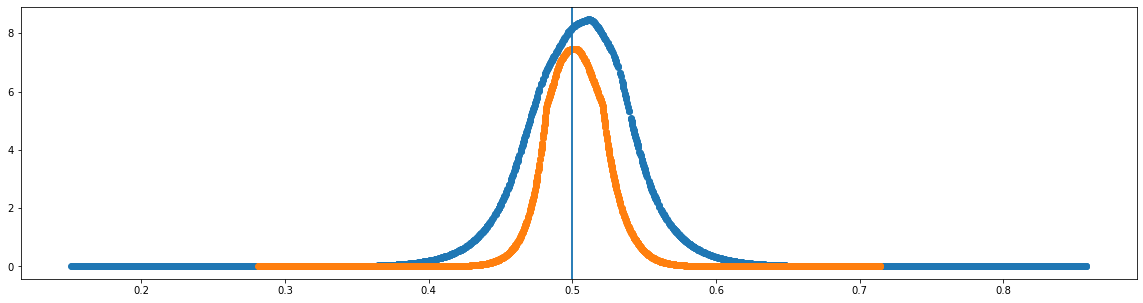

In [12]:
plt.figure(figsize=(20, 5))
for i in range(NDIM):
    zgrid, lnLgrid = sw.posterior(i)
    plt.axvline(z0[i])
    plt.scatter(zgrid[:], np.exp(lnLgrid[:]))

(0.0, 1.0)

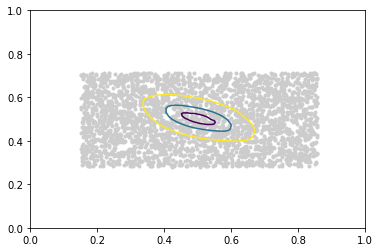

In [13]:
zgrid, lnLgrid = sw.posterior([0, 1])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9])
plt.xlim([0, 1])
plt.ylim([0, 1])